In [33]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table

# from utils import *

In [2]:
files = glob.glob('../data/p112_data_24/*.fits')
files = glob.glob('../data/spectra/*.fits')


In [3]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [4]:
# spectrum = fits.open('../data/spectra/archive/ADP.2023-12-08T12:58:09.704.fits')
# header = spectrum[0].header
# data   = spectrum[1].data

In [5]:
# instrument precision: cm/s
# decription of columns: https://ftp.eso.org/pub/dfs/pipelines/instruments/espresso-das/espda-reflex-tutorial-1.3.7.pdf
# QC CCF RV: computed radial velocity [km s−1

In [34]:
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2024-01-04T12:58:42' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
OBJECT  = 'UCAC4 297-057956'   / Original target.                               
RA      =           141.969218 / [deg] Spectroscopic target position (J2000)    
DEC     =            -30.73381 / [deg] Spectroscopic target position (J2000)    
EXPTIME =                 300. / [s] Total integration time per pixel           
MJD-OBS =       60303.343872

In [35]:
obj_dir = {}
c=3e5 #km/s

for i,file in enumerate(files):
    with fits.open(file) as hdul:
        hdul = fits.open(file)
        header  = hdul[0].header
        data    = hdul[1].data
        time    = header['HIERARCH ESO QC BJD']
        name    = header['OBJECT']
        obj     = header['HIERARCH ESO OBS NAME'].split('-')[0]
        print(obj)
        ra,dec  = header['RA'], header['DEC']
        obs_T   = header['DATE-OBS'].split('T')[0]
        rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
        rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
        sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

        # correct for Earth's motion:
        rv_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value #to convert to km/s
        err_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value
        rv_corr = rv_val + rv_corr + rv_val * rv_corr / c  
        err_corr = rv_err + err_corr + rv_err * err_corr / c  

        if obj in obj_dir.keys():
            obj_dir[obj]['rv'].append(rv_corr)
            obj_dir[obj]['time'].append(time)
            obj_dir[obj]['err'].append(err_corr)
            obj_dir[obj]['name'].append(name)
        else:
            obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 'name': [name]}
            
targets_to_remove = []
for k, v in obj_dir.items():
    if len(v['time']) < 3:
        targets_to_remove.append(k)
for i in range(len(targets_to_remove)):
    del obj_dir[targets_to_remove[i]]
print(len(obj_dir.keys()))


RG24
RG16
RG2
RG5
RG13
RG1
RG24
RG8
RG22
RG4
RG6
RG14
RG1
RG13
RG8
RG5
RG20
RG23
RG7
RG9
RG2
RG24
RG5
RG4
RG25
RG14
RG13
RG6
RG20
RG24
RG22
RG24
RG7
RG15
RG17
RG6
RG7
RG13
RG7
RG14
RG13
RG16
RG7
RG1
RG4
RG2
RG5
RG2
RG1
RG23
RG5
RG2
RG13
RG23
RG4
RG12
RG14
RG1
10


In [ ]:
K = (vr,max −
vr,min)/2:

RG24 4.345712412929874
RG2 3.2910316953304672
RG5 12.069102541490174
RG13 19.9881070844382
RG1 13.899080635783974
RG4 17.776420623465924
RG6 1.5599116125587784
RG14 8.07052361399408
RG23 6.878208737256084
RG7 14.285431602197832


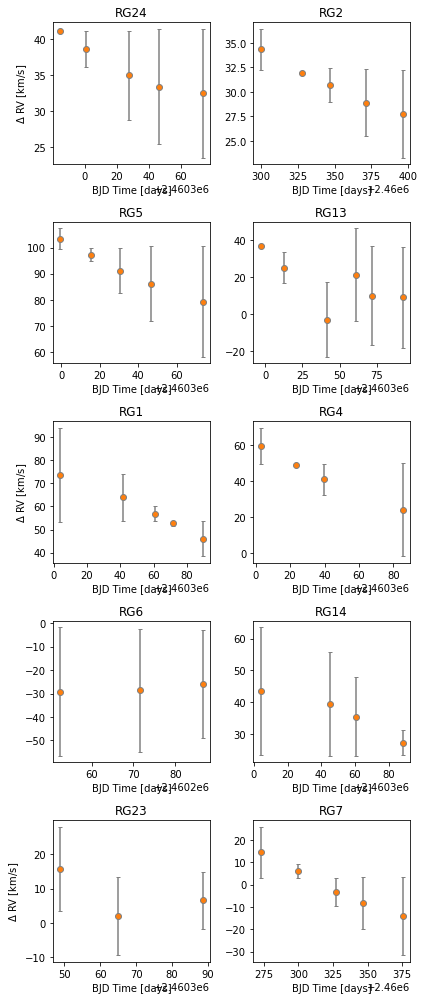

In [38]:
#PLOT_PARAMS(LS=12)
plt.figure(figsize=(6,14))
for i, (obj, dat) in enumerate(obj_dir.items()):
    if len(dat['time']) > 1:
        #print(obj,obj_dir[obj])
        plt.subplot(5,2,i+1)
        time    = np.array(obj_dir[obj]['time'])
        rv_vals = np.array(obj_dir[obj]['rv'])
        t0  = time[0]
        rv0 = rv_vals[0]
        K0 = (max(rv_vals)-min(rv_vals))/2.
        print(obj, K0)
        plt.errorbar(time, rv_vals, 
                     yerr=obj_dir[obj]['err'],
                     fmt='o', color='grey', mec='grey', mfc='C1', capsize=2)
        #plt.axhline(0, color='k',lw=1,ls='dotted')
        plt.title(obj)
    plt.xlabel(r'BJD Time [days]')
    if i+1 in [1,5,9,13]: plt.ylabel(r'$\Delta$ RV [km/s]')

plt.tight_layout()
# plt.savefig('.png', bbox_inches='tight', dpi=200)

In [40]:
import thejoker as tj


/opt/miniconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


AttributeError: module 'matplotlib' has no attribute 'colormaps'

In [39]:
def test_tj(obj):
    data = Table()
    data['bjd'] = obj_dir[obj]['time']
    data['rv'] = obj_dir[obj]['rv']
    data['rv_err'] = obj_dir[obj]['err']
    t = Time(sub_tbl["bjd"], format="jd", scale="tcb")
    data = tj.RVData(t=t, rv=sub_tbl["rv"], rv_err=sub_tbl["rv_err"])

    #t = Time(data["bjd"], format="jd", scale="tcb")
#     data = tj.RVData(t=t, rv=sub_tbl["rv"], rv_err=sub_tbl["rv_err"])
test_tj('RG4')

In [32]:
rnd = np.random.default_rng(seed=42)